# Домашнее задание №3 
## Модели ARIMA и GARCH


Выберите ряд из первого задания и постройте его модель ARIMA/GARCH. Отчет нужно будет оформить в jupyter-ноутбук.
Дополнительное задание: попробуйте спрогнозировать график классическим ML.
___

1. Загрузка библиотек
2. Определение базовых функций для исследования рядов и их предсказания
3. Загрузка датасета (исследуем датасет с уровнем выброса CO2 в атмосферу в районе вулкана Мауна-Лоу на Гавайях)  
4. Предварительный визуальный анализ выбранного временного ряда
5. Манипуляции с рядом:  
    5.1 Эксперименты с приведением ряда к стационарному
    5.2 Модели авторегрессии AR
    5.3 Применение модели ARIMA  
    5.4 Применение модели GARCH  
    5.5 Используем классический ML  
6. Дополнительные эксперименты с датасетом ежемесячных продаж в компании Х

## 1. Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.stats import boxcox
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## 2. Определяем функции
За основу берем функции из лекционного ноутбука

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh', plot_title='Original'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title(plot_title)

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

## 3. Загрузка и предварительный анализ датасета

Поскольку дальше использовать датасеты из лекционных примеров кажется не вполне спортивным, я решил использовать другие источники данных.  
В состав библиотеки statsmodels входит коллекция датасетов, которые можно использовать для анализа.  
Одним из датасетов, который показался мне интересным, является измерение выброса углекислого газа в обсерватории Мауна-Лоа, размещенной на Гавайях.
Этот датасет описан на сайте библиотеки: https://www.statsmodels.org/dev/datasets/generated/co2.html

##### Загружаем датасет и смотрим его характеристики:

In [4]:
data = sm.datasets.co2.load_pandas()
df = data.data
df.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


Поскольку согласно описанию ряда измерения проводились в течение продолжительного времени и возможность их проведения зависела в том числе от погодных условий, есть вероятность, что в данных могут быть пропуски. В этой связи проверим, так ли это.

In [5]:
ser = data.data.co2
print(f'Количество пропусков в датасете NaN = {ser.isna().sum()}')
ser.describe()

Количество пропусков в датасете NaN = 59


count    2225.000000
mean      340.142247
std        17.003885
min       313.000000
25%       324.800000
50%       338.300000
75%       354.800000
max       373.900000
Name: co2, dtype: float64

## 4. Предварительный визуальный анализ

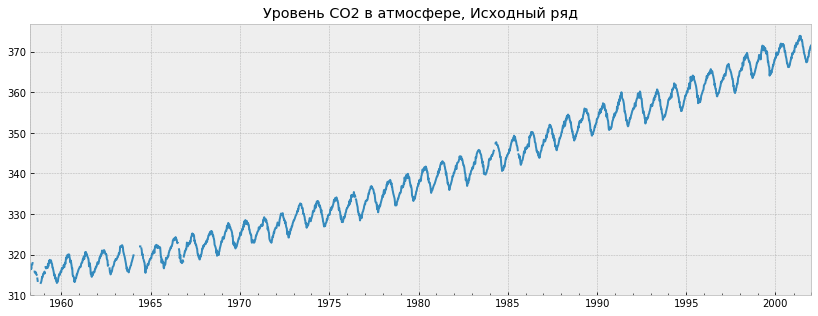

In [6]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 5))
    ser.plot()
    plt.title('Уровень CO2 в атмосфере, Исходный ряд')

Поскольку пропуски обнаружились, а их наличие не позволит использовать проверку на стационарность ряда, заменим пропуски на ближайшее ненулевое значение. Учитывая характер графика кажется более рациональным заменять данные на предыдущее значение плюс разность предыдущего и предпредыдущего значения, но пока используем самый простой вариант.

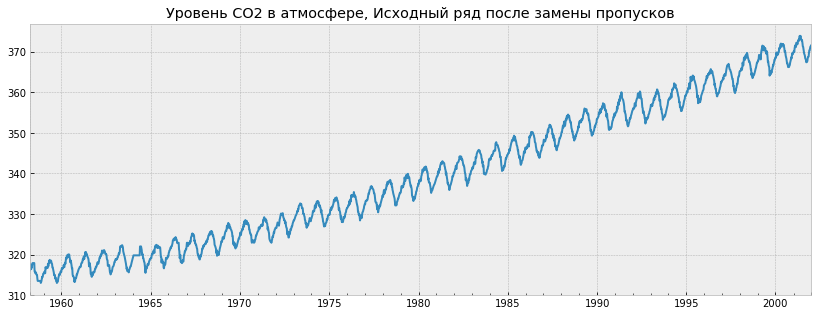

In [7]:
ser2 = ser.fillna(method='ffill')
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 5))
    ser2.plot()
    plt.title('Уровень CO2 в атмосфере, Исходный ряд после замены пропусков')

Поскольку в районе 1964 года был период с несколькими пропусками подряд, а также учитывая достаточно большой запас данных, возьмем для дальнейшего анализа фрагмент датасета (последние 1000 измерений)

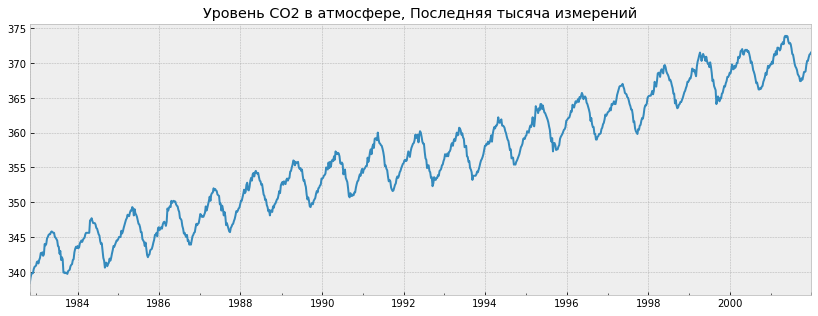

In [8]:
ser3 = ser2.iloc[-1000:]
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 5))
    ser3.plot()
    plt.title('Уровень CO2 в атмосфере, Последняя тысяча измерений')

Отлично, ряд готов к экспериментам. Видно, что ряд не является стационарным. В нем явно присутствуют и ярко выраженный тренд, и сезонность. Дисперсия же по ощущениям более-менее постоянная. Запустим в первый раз определенную вначале функцию для анализа стационарности ряда.

Results of Dickey-Fuller Test:
Test Statistic                  -1.208199
p-value                          0.670059
#Lags Used                      16.000000
Number of Observations Used    983.000000
Critical Value (1%)             -3.437020
Critical Value (5%)             -2.864485
Critical Value (10%)            -2.568338
dtype: float64


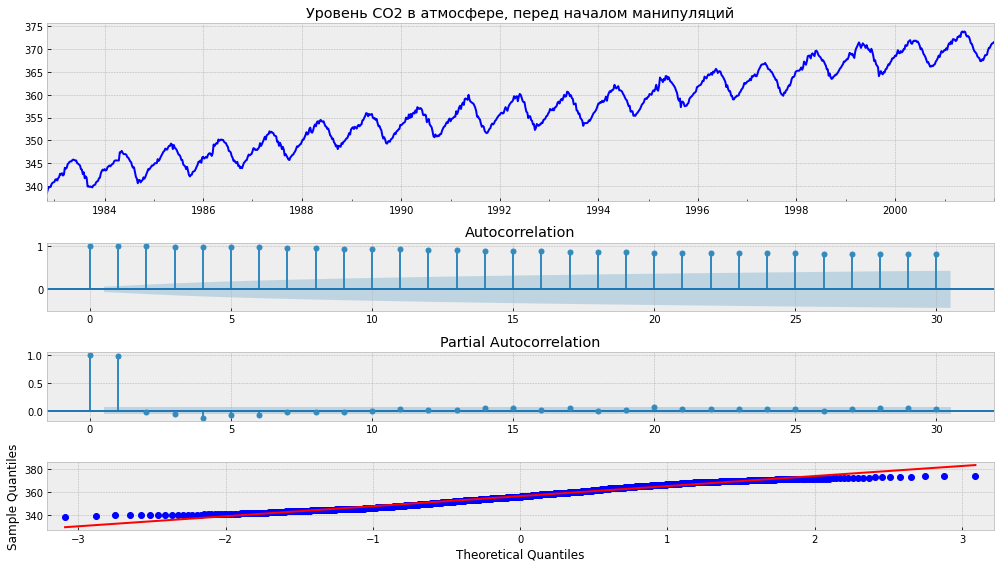

In [9]:
tsplot(ser3, plot_title='Уровень CO2 в атмосфере, перед началом манипуляций')

## 5. Манипуляции с данными

#### 5.1 BoxCox, дифференцирование
Хотя нормализацией дисперсии в данном случае заниматься не обязательно, все-таки попробуем применить BoxCox и посмотрим на эффекты

Results of Dickey-Fuller Test:
Test Statistic                  -1.241537
p-value                          0.655477
#Lags Used                      16.000000
Number of Observations Used    983.000000
Critical Value (1%)             -3.437020
Critical Value (5%)             -2.864485
Critical Value (10%)            -2.568338
dtype: float64


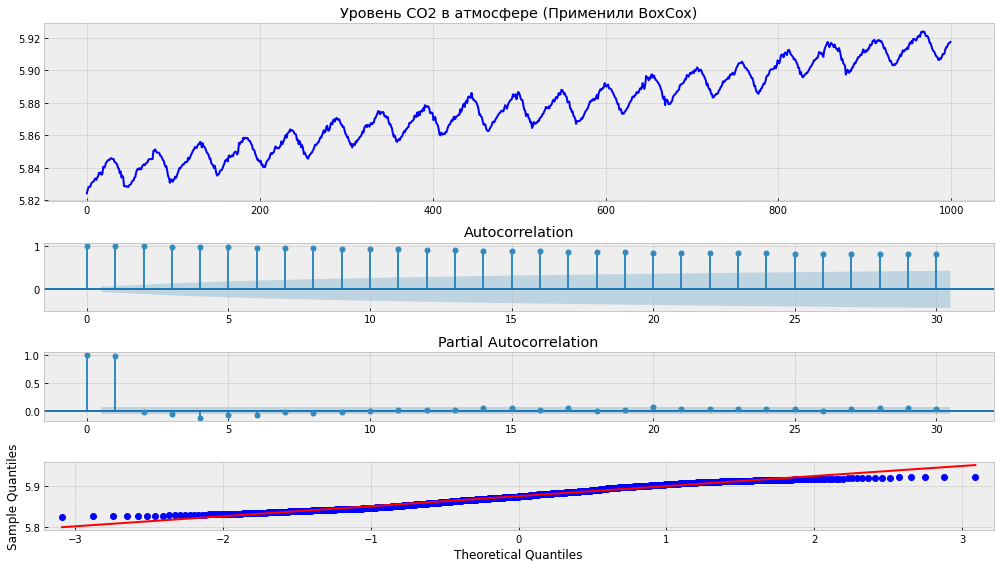

In [10]:
ser4 = boxcox(ser3, 0)
tsplot(ser4, plot_title='Уровень CO2 в атмосфере (Применили BoxCox)')

Действительно видим, что ряд по-прежнему не стационарен.

Results of Dickey-Fuller Test:
Test Statistic                -1.018328e+01
p-value                        6.608633e-18
#Lags Used                     1.500000e+01
Number of Observations Used    9.830000e+02
Critical Value (1%)           -3.437020e+00
Critical Value (5%)           -2.864485e+00
Critical Value (10%)          -2.568338e+00
dtype: float64


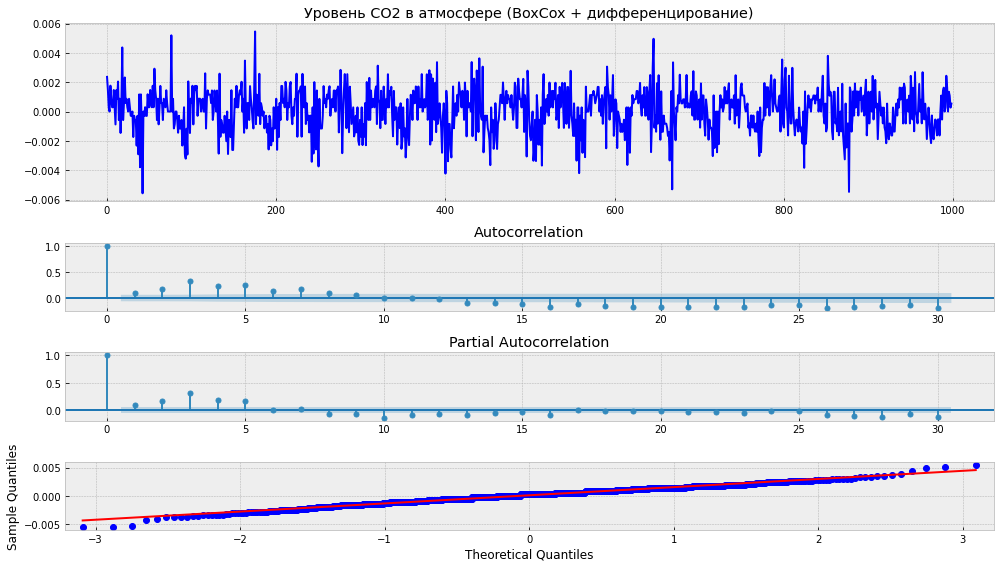

In [11]:
ser5 = ser4[1:] - ser4[:-1]
tsplot(ser5, plot_title='Уровень CO2 в атмосфере (BoxCox + дифференцирование)')

Хотя получившиеся после дифференцирования статистические характеристики уже позволяют считать ряд стационарным, есть основания полагать, что распределение у нас пока не нормальное (это заметно по последнему графику с квантилями - на "хвостах" у нас наблюдаются заметные отклонения.
В нашем ряду сохранилась сезонность. Очевидно, она равна 1 году, но поскольку измерения проводились не ежемесячно, а еженедельно, а количество недель в году не является целым числом (примерно 52.1786 недель в году). можно осторожно попробовать избавиться от сезонности, вычитая ряд сам из себя со смещением в 52 измерения.

Results of Dickey-Fuller Test:
Test Statistic                -1.223241e+01
p-value                        1.046339e-22
#Lags Used                     1.300000e+01
Number of Observations Used    9.330000e+02
Critical Value (1%)           -3.437378e+00
Critical Value (5%)           -2.864643e+00
Critical Value (10%)          -2.568422e+00
dtype: float64


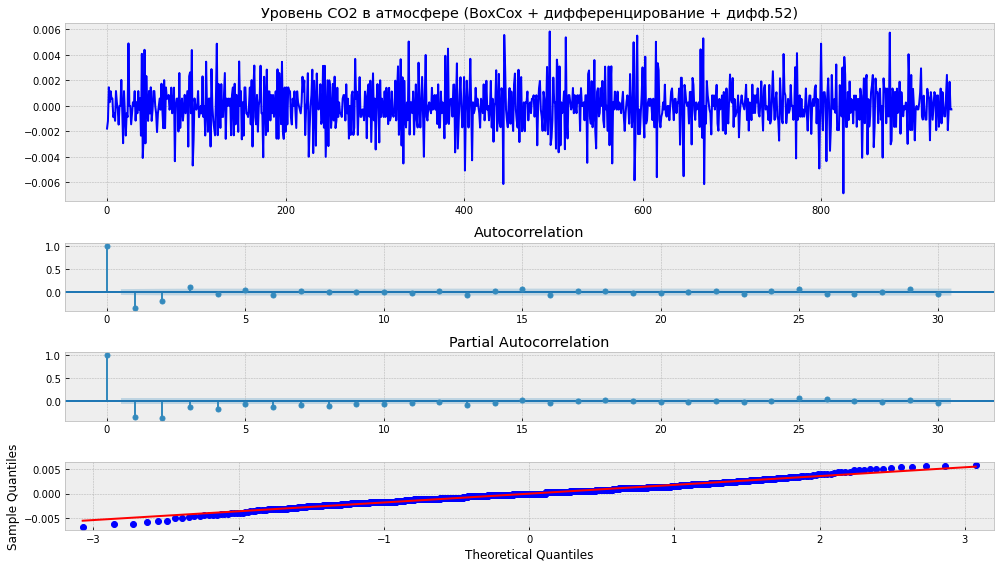

In [12]:
ser6 = ser5[52:] - ser5[:-52]
tsplot(ser6, plot_title='Уровень CO2 в атмосфере (BoxCox + дифференцирование + дифф.52)')

Действительно эта операция привела к улучшению характеристик ряда как стационарного. Это видно и по графикам автокорреляции, и частичной автокорреляции, и соотношения квантилей.

#### 5.2 Модели авторегрессии AR и ARMA

##### 5.2.1 AR на исходной выборке
Поскольку предположительная сезонность ряда равна году, а считаем мы данные понедельно, при вызове функции AR параметр maxlag я задал равным 60, чтобы 52 значения ряда могли в полученной модели обладать влиянием.

In [13]:
mdl_ar_original = smt.AR(ser3).fit(maxlag=60, ic='aic', trend='c')
for k, v in enumerate(mdl_ar_original.params):
    print(f'{k} = {v}')

0 = -0.0398433277070076
1 = 0.5492801705095967
2 = 0.04732521982732418
3 = 0.19334439463234254
4 = 0.016511955608983886
5 = 0.08413593055731772
6 = -0.056818331792747756
7 = 0.07861629292719075
8 = -0.030729120469052518
9 = 0.038653819722992644
10 = -0.029825985591832804
11 = 0.036983955735848006
12 = 0.005909903378769066
13 = 0.007551326267117631
14 = -0.007246964601588246
15 = 0.0049768476337677114
16 = -0.04175716999025436
17 = 0.04622917929719339
18 = -0.034013559594201936
19 = 0.006927128230520552
20 = -0.027783012058742784
21 = 0.005023355965141363
22 = -0.0037165977033950526
23 = 0.02066804957522317
24 = 0.051986287976460765
25 = 0.018826847976212036
26 = -0.07002716090810474
27 = 0.004223740026302936
28 = -0.009115129849890158
29 = 0.05013751545379552
30 = -0.037909069654420646
31 = 0.026738559501727988
32 = -0.0032281499040860417
33 = 0.02574642935911653
34 = -0.05900958455079541
35 = 0.007208358939948756
36 = 0.01909685610785411
37 = -0.0626072742412484
38 = 0.015123291522021

Results of Dickey-Fuller Test:
Test Statistic                 -31.054116
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    939.000000
Critical Value (1%)             -3.437333
Critical Value (5%)             -2.864623
Critical Value (10%)            -2.568412
dtype: float64


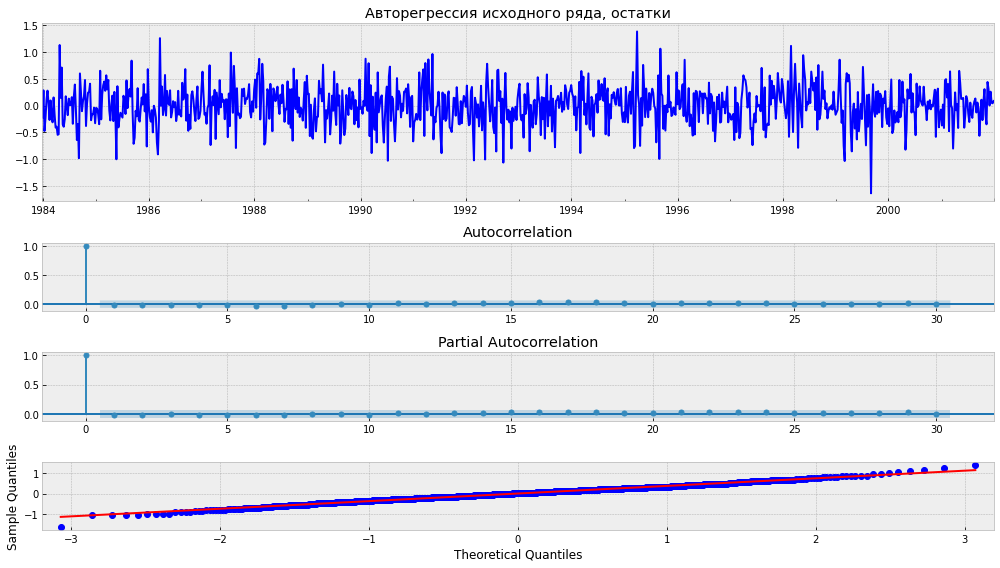

In [14]:
# Смотрим остатки
tsplot(mdl_ar_original.resid, plot_title="Авторегрессия исходного ряда, остатки")

##### 5.2.1 AR на стабилизированной выборке

In [15]:
mdl_ar_stab = smt.AR(ser6).fit(maxlag=60, ic='aic', trend='nc')
for k, v in enumerate(mdl_ar_stab.params):
    print(f'{k} = {v}')

0 = -0.5189408937505255
1 = -0.5175615087384913
2 = -0.3629998292504629
3 = -0.32662756385331637
4 = -0.2425087238079981
5 = -0.32043844043593783
6 = -0.2259587759458344
7 = -0.18670654278964133
8 = -0.1453855012970753
9 = -0.11883837117488472
10 = -0.10087432725968794
11 = -0.06300051070773993
12 = -0.03428845960413419
13 = -0.012451781085399592
14 = 0.0021895522756970043
15 = 0.01763078318103374
16 = 0.039954494375954414
17 = 0.05634358154611119
18 = 0.02461878103058255
19 = 0.009524310521068793
20 = 0.025716434605929032
21 = 0.033368600246575425
22 = 0.058188491305090566
23 = 0.0787623253374956
24 = 0.10060634809254387
25 = 0.017411598174855384
26 = 0.03425857563217982
27 = 0.011698603774033142
28 = 0.07291182767025123
29 = 0.037144995336454316
30 = 0.09422979779818494
31 = 0.06361155010743813
32 = 0.08065893379892333
33 = 0.07847555362199017
34 = 0.06517076954498405
35 = 0.0777061229781313
36 = 0.013647427550102554
37 = 0.03684684406894795
38 = 0.0646174299219478
39 = 0.06655768514

Results of Dickey-Fuller Test:
Test Statistic                 -29.703164
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    888.000000
Critical Value (1%)             -3.437735
Critical Value (5%)             -2.864800
Critical Value (10%)            -2.568506
dtype: float64


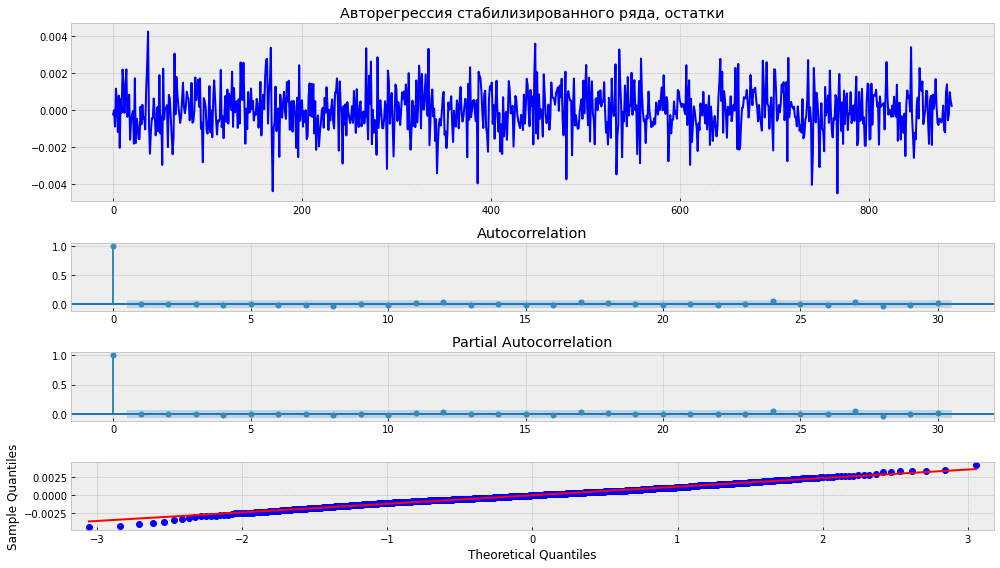

In [16]:
# Смотрим остатки
tsplot(mdl_ar_stab.resid, plot_title="Авторегрессия стабилизированного ряда, остатки")

Статистически результаты кажутся неплохими, но меня смущают большие значения первых десяти коэффициентов при просчете модели для стабилизированной выборки.

#### 5.3 ARIMA (p,d,q)

ARIMA - естественное расширение модели ARMA. Как мы уже хорошо знаем - многие временные ряды не стационарны, но они могут такими стать в результате операции дифференцирования. В модели ARIMA "дифференцирование" (в количестве d-раз) вносится в саму модель


$\delta^p y_t = c + \sum_{i=1}^p a_i \delta^d y_{t-i} + \sum_{j=1}^q b_j \epsilon_{t-j} + \epsilon_t$

aic: 1278.08142 | order: (4, 1, 2)
Results of Dickey-Fuller Test:
Test Statistic                 -31.646574
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    998.000000
Critical Value (1%)             -3.436919
Critical Value (5%)             -2.864440
Critical Value (10%)            -2.568314
dtype: float64


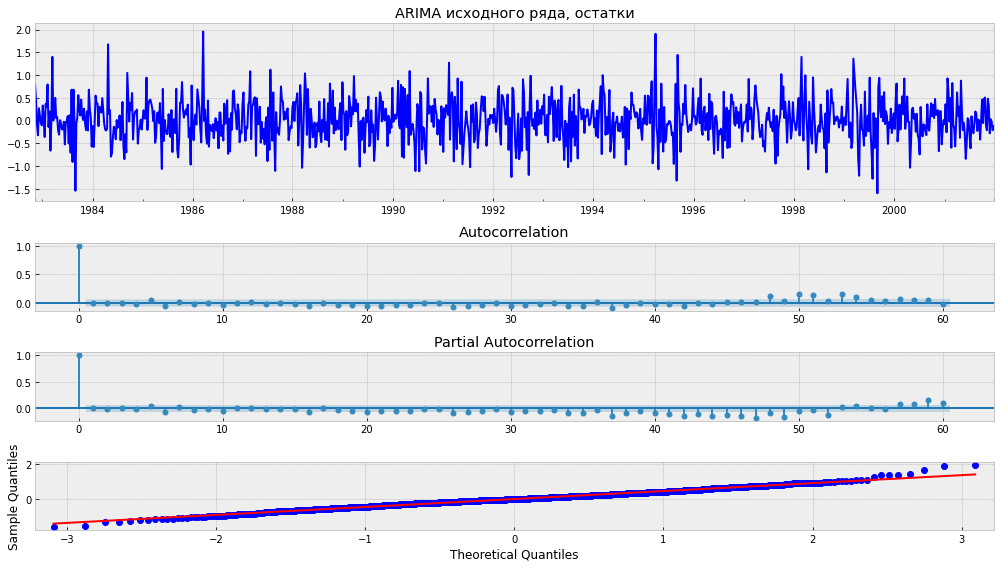

In [17]:
series = ser3.copy()

best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=60, plot_title='ARIMA исходного ряда, остатки')

In [32]:
best_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.co2   No. Observations:                  999
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -632.041
Method:                           mle   S.D. of innovations              0.455
Date:                Sat, 12 Nov 2022   AIC                           1278.081
Time:                        16:04:20   BIC                           1312.429
Sample:                    11-13-1982   HQIC                          1291.136
                         - 12-29-2001                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ar.L1.D.co2     1.5772      0.046     34.445      0.000       1.487       1.667
ar.L2.D.co2    -0.5687      0.067     -8.534      0.000      -0.699      -0.438
ar.L3.D.co2     0.1058      0.061      1.723      0.085      -0.015       0.226
ar.L4.D.co2    -0.1708      0.036     -4.748      0.000      -0.241      -0.100
ma.L1.D.co2    -1.6980      0.037    -45.672      0.000      -1.771      -1.625
ma.L2.D.co2     0.8018      0.035     22.862      0.000       0.733       0.871
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0378           -0.2039j            1.0577           -0.0309
AR.2            1.0378           +0.2039j            1.0577            0.0309
AR.3           -0.7281           -2.1686j            2.2875           -0.3016
AR.4           -0.7281           +2.1686j            2.2875            0.3016
MA.1            1.0589           -0.3550j            1.1168           -0.0515
MA.2            1.0589           +0.3550j            1.1168            0.0515
-----------------------------------------------------------------------------
"""

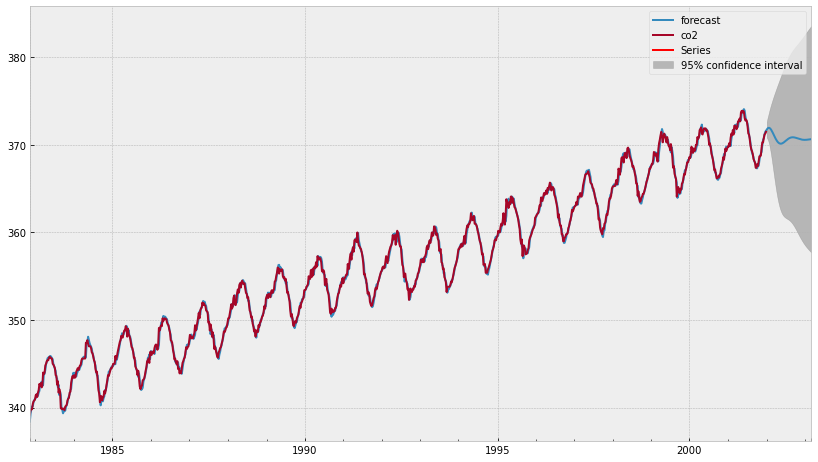

In [21]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(1, len(series)+60, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

Полученный результат мне совсем не нравится. Вообще подбор параметров и поиск лучшего набора коэффициентов в цикле с перебором комбинаций по количеству параметров от 0 до 5 по каждому из коэффициентов с одной стороны дает шансы более-менее описать существующий ряд, но с предсказаниями тут явно что-то не работает. Мне кажется, что связано это с тем, что у нас - большой порядок периода цикличности. На получившемя графике с предсказаниями видно то, что и период колебаний предсказанной кривой меньше, чем у основного ряда, и затухание происходит быстро, и размах возможного коридора значений слишком велик..

#### 5.4 GARCH

Добавляем зависимость от прошлых значений самой условной дисперсии. Получаем модель GARCH(p, q)

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2$

GARCH - по сути - модель ARMA примененная к дисперсии ряда

* До начала своих экспериментов сразу фикрсирую свой прогноз, что результаты и этого метода могут мне не понравиться.. Но посмотрим.

In [28]:
# To install this package run one of the following:
# conda install -c conda-forge arch-py
# conda install -c "conda-forge/label/cf202003" arch-py
from arch import arch_model

Применим GARCH

In [29]:
# В соответствии с рекомендацией о том, что коэффициенты для модели ARIMA 
# скорее всего будут лучшими и для модели GARCH, инициализируем коэффициенты:
p_ = 4
o_ = 1
q_ = 2

# Также, как и в лекции, используем рекомендованное распределение Стьюдента
am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                          co2   R-squared:                      -0.018
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.018
Vol Model:                        GJR-GARCH   Log-Likelihood:               -3125.14
Distribution:      Standardized Student's t   AIC:                           6270.29
Method:                  Maximum Likelihood   BIC:                           6319.36
                                              No. Observations:                 1000
Date:                      Sat, Nov 12 2022   Df Residuals:                      990
Time:                              15:43:06   Df Model:                           10
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

Results of Dickey-Fuller Test:
Test Statistic                  -1.208199
p-value                          0.670059
#Lags Used                      16.000000
Number of Observations Used    983.000000
Critical Value (1%)             -3.437020
Critical Value (5%)             -2.864485
Critical Value (10%)            -2.568338
dtype: float64


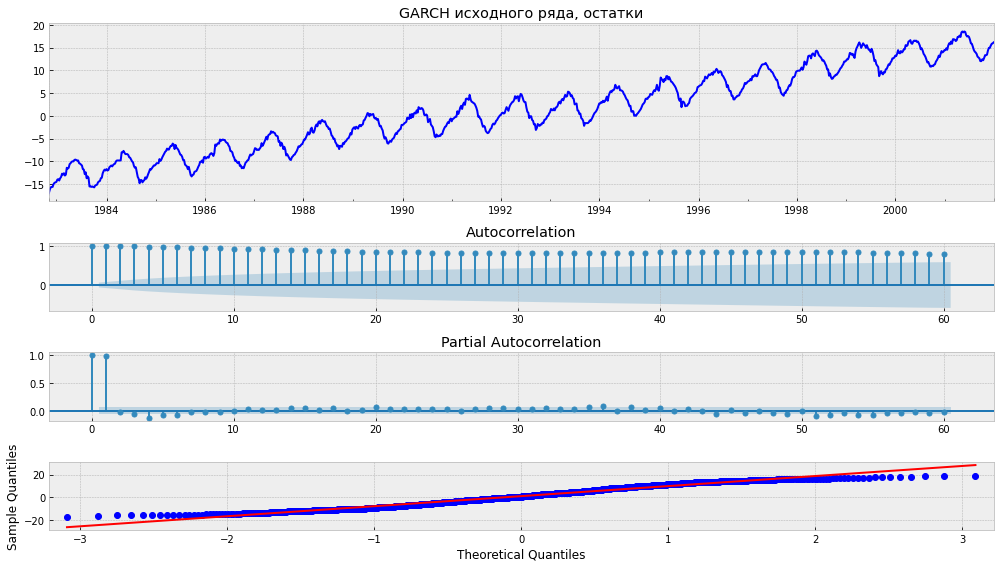

In [31]:
tsplot(res.resid, lags=60, plot_title='GARCH исходного ряда, остатки')

Кажется, результат получился ужасным. Судя по подсчитанным на две ячейки выше коэффициентам у нас фактически график сдвинулся  по вертикали, а все его остальные особенности сохранились.

У меня нет идей, что произошло и можно ли было в принципе получить хорошие результаты с этим рядом. В этой связи, видимо, попробую всю эту историю повторить с одним из лекционных датасетов - месячными продажами магазина Х...

## 6. Загружаем датасет «Ежемесячные продажи магазина Х»

In [33]:
df_sales = pd.read_csv("../Series/monthly-sales-of-company-x-jan-6.csv")
df_sales.head()

,Month,Count
0,1965-01,154
1,1965-02,96
2,1965-03,73
3,1965-04,49
4,1965-05,36


In [35]:
seria_sales_raw = df_sales['Count']

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


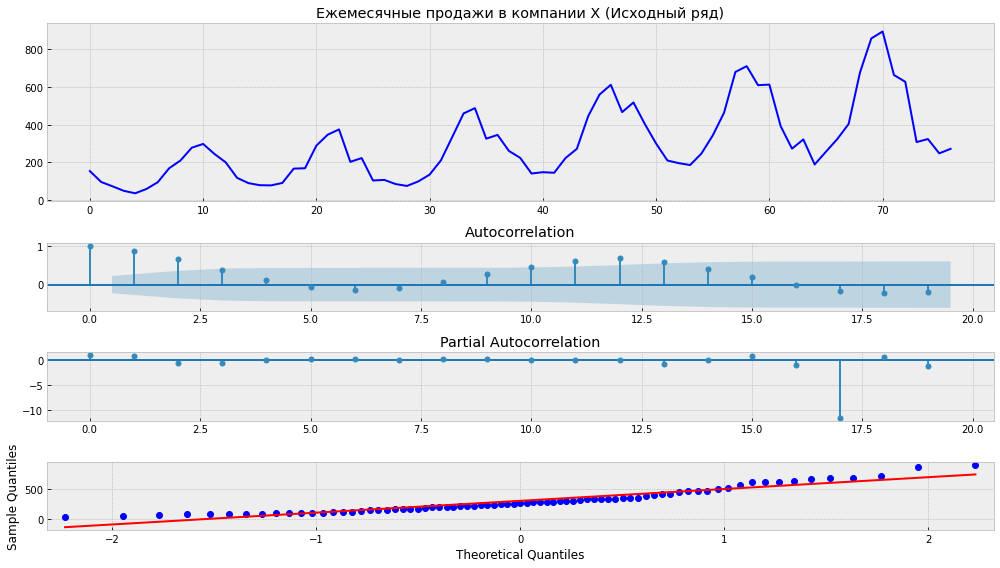

In [36]:
 tsplot(seria_sales_raw, plot_title='Ежемесячные продажи в компании Х (Исходный ряд)')

## 7. Получаем стабилизированную версию ряда
Анализируемый ряд, как хорошо видно, имеет и тренд, и сезонность, и заметную гетероскедастичность

Results of Dickey-Fuller Test:
Test Statistic                 -5.290390
p-value                         0.000006
#Lags Used                      9.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


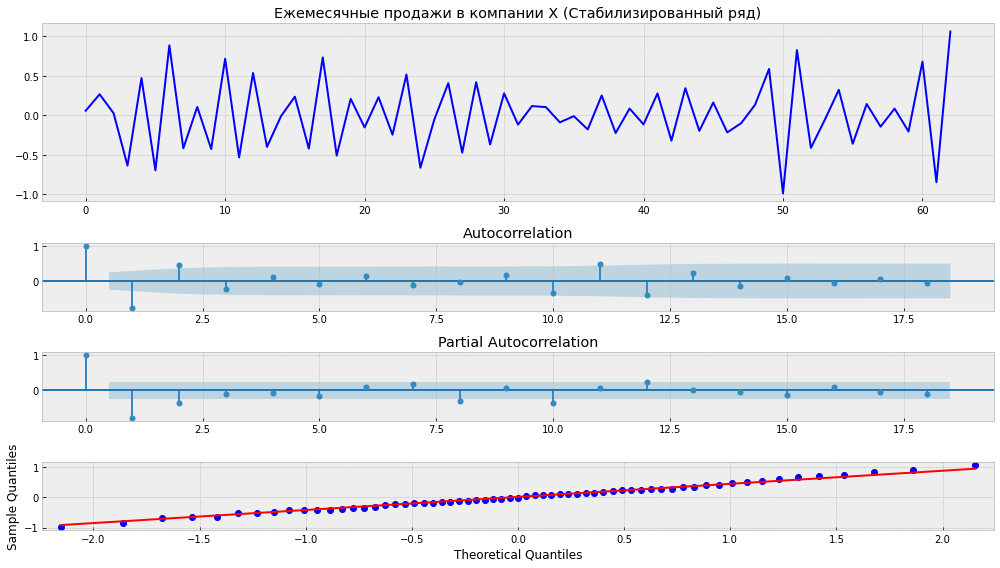

In [43]:
seria_sales_stab = boxcox(seria_sales_raw, 0)
seria_sales_stab = seria_sales_stab[1:] - seria_sales_stab[:-1]
seria_sales_stab = seria_sales_stab[12:] - seria_sales_stab[:-12]
seria_sales_stab = seria_sales_stab[1:] - seria_sales_stab[:-1]

tsplot(seria_sales_stab, plot_title='Ежемесячные продажи в компании Х (Стабилизированный ряд)')

## 8. ARIMA для датасета «Ежемесячные продажи магазина Х»

aic: 858.17298 | order: (3, 1, 2)
Results of Dickey-Fuller Test:
Test Statistic                 -2.024893
p-value                         0.275766
#Lags Used                     11.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64
aic: 858.17298 | order: (3, 1, 2)


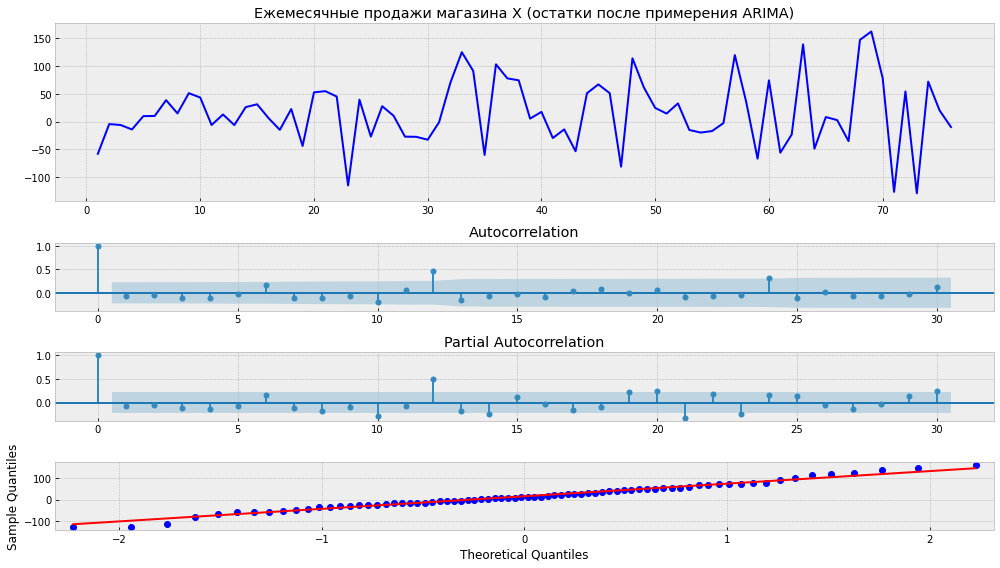

In [41]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(seria_sales_raw, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30, plot_title="Ежемесячные продажи магазина X (остатки после примерения ARIMA)")


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

In [44]:
best_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Count   No. Observations:                   76
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -423.086
Method:                           mle   S.D. of innovations             60.549
Date:                Sat, 12 Nov 2022   AIC                            858.173
Time:                        17:31:56   BIC                            872.157
Sample:                             1   HQIC                           863.762
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1.D.Count     1.3556      0.116     11.730      0.000       1.129       1.582
ar.L2.D.Count    -0.3700      0.199     -1.863      0.062      -0.759       0.019
ar.L3.D.Count    -0.3523      0.117     -3.019      0.003      -0.581      -0.124
ma.L1.D.Count    -1.8054      0.098    -18.462      0.000      -1.997      -1.614
ma.L2.D.Count     0.9219      0.081     11.377      0.000       0.763       1.081
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8710           -0.5078j            1.0082           -0.0840
AR.2            0.8710           +0.5078j            1.0082            0.0840
AR.3           -2.7923           -0.0000j            2.7923           -0.5000
MA.1            0.9792           -0.3549j            1.0415           -0.0553
MA.2            0.9792           +0.3549j            1.0415            0.0553
-----------------------------------------------------------------------------
"""

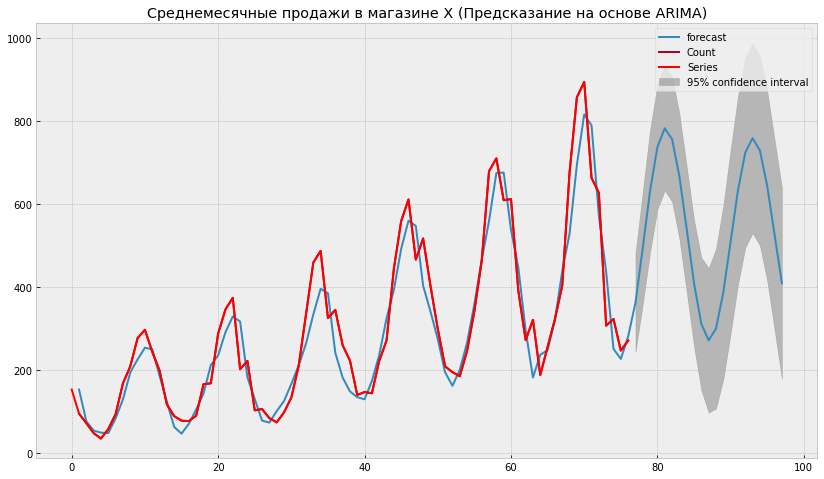

In [46]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(1, len(seria_sales_raw)+20, ax=ax)
    plt.plot(seria_sales_raw, color='red', label='Series')
    plt.title('Среднемесячные продажи в магазине Х (Предсказание на основе ARIMA)')
    plt.legend()
    plt.show()

Результат для этого ряда уже кажется интересным, хотя видно, что тренд тут потерялся.

## 9. GARSH для датасета «Ежемесячные продажи магазина Х»

In [49]:
# В соответствии с рекомендацией о том, что коэффициенты для модели ARIMA 
# скорее всего будут лучшими и для модели GARCH, инициализируем коэффициенты:
p_ = 3
o_ = 1
q_ = 2

# Также, как и в лекции, используем рекомендованное распределение Стьюдента
am = arch_model(seria_sales_stab, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                      -0.002
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.002
Vol Model:                        GJR-GARCH   Log-Likelihood:               -29.0989
Distribution:      Standardized Student's t   AIC:                           76.1979
Method:                  Maximum Likelihood   BIC:                           95.4861
                                              No. Observations:                   63
Date:                      Sat, Nov 12 2022   Df Residuals:                       54
Time:                              17:46:22   Df Model:                            9
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0

Results of Dickey-Fuller Test:
Test Statistic                 -5.290390
p-value                         0.000006
#Lags Used                      9.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


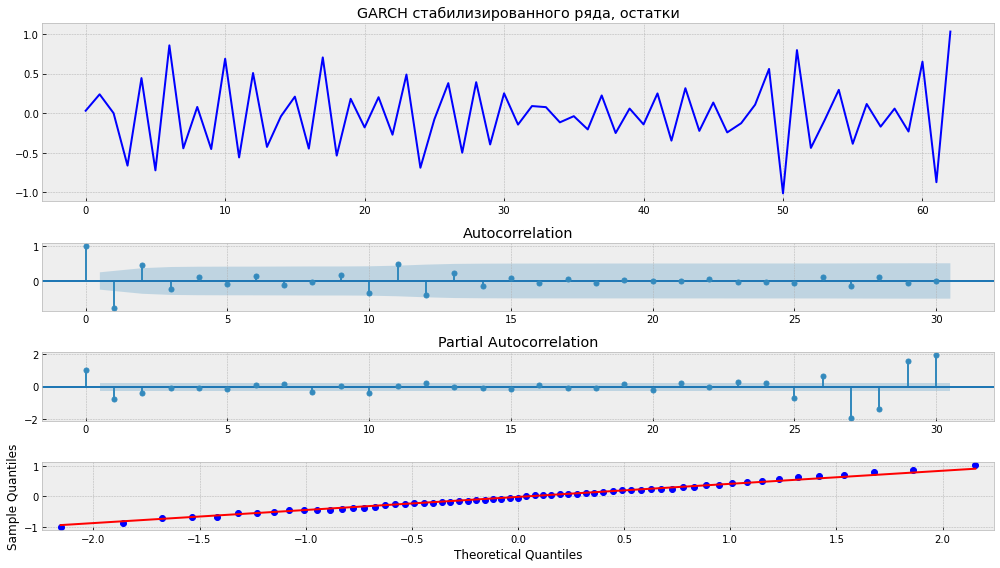

In [51]:
tsplot(res.resid, lags=30, plot_title='GARCH стабилизированного ряда, остатки')

И снова я не понимаю результата с GARSH. Фактически при запуске модели GARSH при отображении графика остатков мы получаем кривую, точно повторяющую по форме кривую исходного ряда, который "скармливался" модели GARCH.
Я эти результаты ни объяснить, ни понять пока не могу.

## 10. Используем классический ML для датасета «Ежемесячные продажи магазина Х»

In [54]:
# Возьмем за основу лекционную функцию
def prepareData(data, lag_start=1, lag_end=20, test_size=0.15, drop_columns=["Month"]):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(drop_columns, axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    return X_train, X_test, y_train, y_test

In [97]:
X_train, X_test, y_train, y_test = prepareData(df_sales, lag_start=1, lag_end=15, test_size=0.3, drop_columns=["Month"])
X_train.head()

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14
0,118.0,200.0,245.0,298.0,278.0,210.0,169.0,95.0,59.0,36.0,49.0,73.0,96.0,154.0
1,90.0,118.0,200.0,245.0,298.0,278.0,210.0,169.0,95.0,59.0,36.0,49.0,73.0,96.0
2,79.0,90.0,118.0,200.0,245.0,298.0,278.0,210.0,169.0,95.0,59.0,36.0,49.0,73.0
3,78.0,79.0,90.0,118.0,200.0,245.0,298.0,278.0,210.0,169.0,95.0,59.0,36.0,49.0
4,91.0,78.0,79.0,90.0,118.0,200.0,245.0,298.0,278.0,210.0,169.0,95.0,59.0,36.0


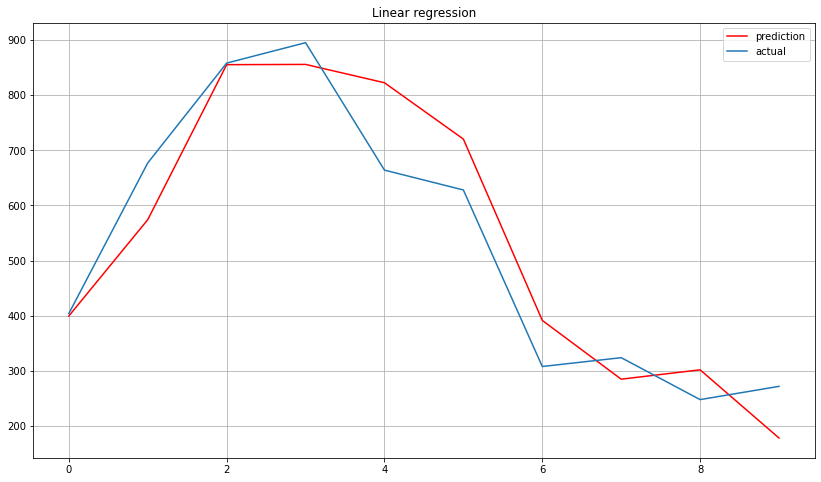

In [98]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

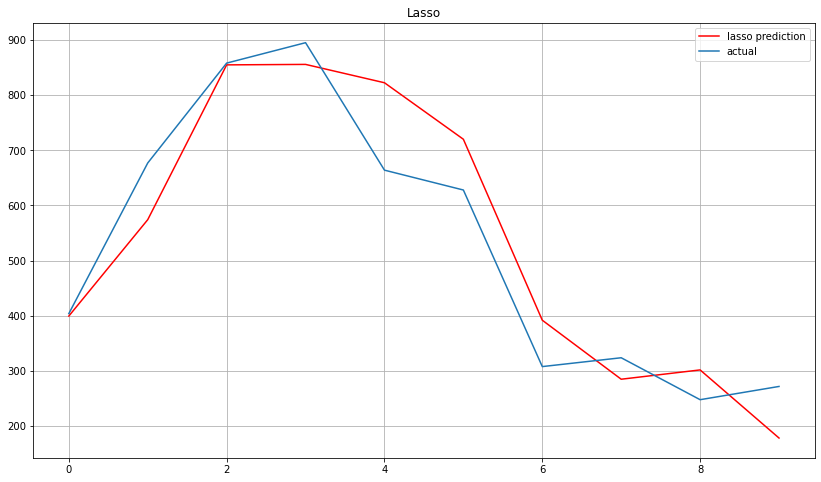

In [99]:
# Я попробовал также использовать алгоритмы Lasso, ElasticNet, и при использовании любых алгоритмов
# предсказания получаются идентичными.
from sklearn.linear_model import ElasticNet

lr2 = ElasticNet(l1_ratio=0.6, random_state=42)
lr2.fit(X_train, y_train)
prediction2 = lr2.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction2, "r", label="lasso prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Lasso")
plt.grid(True);

Метод для предсказания работает неплохо, при том что в обучающей выборке данных совсем не много. Конечно, эту технологию предсказания лучше потестировать на более длинных рядах..

## 11. Вернемся к исходному ряду с углекислым газом и попробуем использовать линейную регрессию для предсказаний этого ряда.

In [108]:
df_co2 = pd.DataFrame(ser3)
df_co2['Index'] = df_co2.index
df_co2.columns = ['Count', 'Month']
df_co2.head()

,Count,Month
1982-11-06,338.4,1982-11-06
1982-11-13,339.2,1982-11-13
1982-11-20,339.7,1982-11-20
1982-11-27,339.8,1982-11-27
1982-12-04,339.8,1982-12-04


In [120]:
X_train2, X_test2, y_train2, y_test2 = prepareData(df_co2, lag_start=1, lag_end=5, test_size=0.3, drop_columns=["Month"])
X_train3, X_test3, y_train3, y_test3 = prepareData(df_co2, lag_start=1, lag_end=20, test_size=0.3, drop_columns=["Month"])
X_train4, X_test4, y_train4, y_test4 = prepareData(df_co2, lag_start=1, lag_end=60, test_size=0.3, drop_columns=["Month"])

X_train2.head()


,lag_1,lag_2,lag_3,lag_4
0,339.8,339.7,339.2,338.4
1,339.8,339.8,339.7,339.2
2,340.4,339.8,339.8,339.7
3,340.7,340.4,339.8,339.8
4,340.8,340.7,340.4,339.8


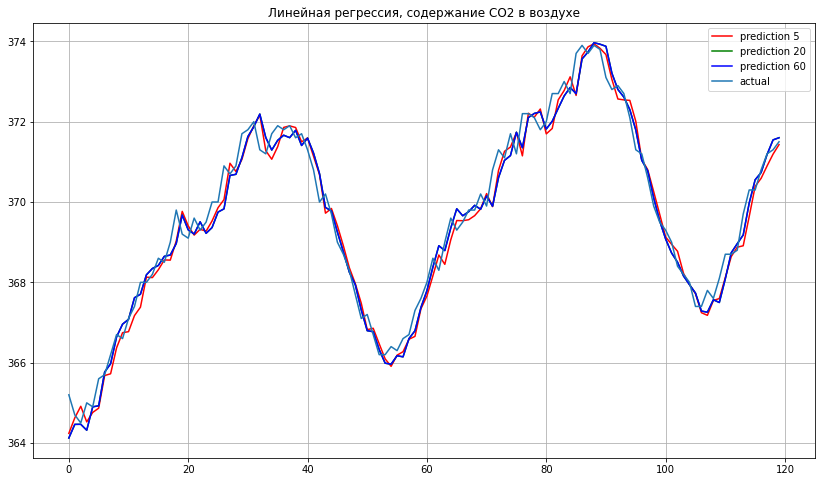

In [122]:
lr_CO2 = LinearRegression()
lr_CO2.fit(X_train2, y_train2)
prediction_CO2 = lr_CO2.predict(X_test2)

lr_CO2_3 = LinearRegression()
lr_CO2_3.fit(X_train3, y_train3)
prediction_CO2_3 = lr_CO2_3.predict(X_test3)

lr_CO2_4 = LinearRegression()
lr_CO2_4.fit(X_train4, y_train4)
prediction_CO2_4 = lr_CO2_4.predict(X_test4)


plt.figure(figsize=(14, 8))
plt.plot(prediction_CO2[-120:], "r", label="prediction 5")
plt.plot(prediction_CO2_3[-120:], "g", label="prediction 20")
plt.plot(prediction_CO2_3[-120:], "b", label="prediction 60")
plt.plot(y_test2.values[-120:], label="actual")
plt.legend(loc="best")
plt.title("Линейная регрессия, содержание CO2 в воздухе")
plt.grid(True);

Кажется, не плохой результат. Для его получения были сгенерированы три разных датасета, с 5, 20 и 60 дополнительными колонками соответственно. Видно, что для 20 и 60 колонок результат предсказания практически сливается. При этом есть ощущение, что у пятиколоночной версии датасета предсказания сильнее смещены вправо относительно исходной кривой.

In [125]:
scr_02 = lr_CO2.score(X_train2, y_train2)
scr_03 = lr_CO2_3.score(X_train3, y_train3)
scr_04 = lr_CO2_4.score(X_train4, y_train4)
print(f'Коэффициенты дискриминации для трех вариантов предсказаний:')
print(f'По пяти колонкам: {scr_02}')
print(f'По двадцати колонкам: {scr_03}')
print(f'По шестидесяти колонкам: {scr_04}')

Коэффициенты дискриминации для трех вариантов предсказаний:
По пяти колонкам: 0.9936903319692961
По двадцати колонкам: 0.9945750656707442
По шестидесяти колонкам: 0.9963848383495141


Действительно, коэффициент детерминации улучшается при увеличении количества колонок. Поскольку датасет небольшой, можно на количестве колонок не экономить ради более точного предсказания :)